# Deep Learning Assignment

This notebook uses satellite images collected in wake of the aftermath of Hurricane Harvey to train a Image Classification model to detect buildings which contain damage caused by hurricanes by using a custom CNN based on the AlexNet architecture and also using the pretrained EfficientNet model, thereafter comparing their performance

In [ ]:
#Loading in libraries
import os
import pandas as pd
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import Sequence
from random import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
!git clone https://github.com/BMQH3/Hurricane.git

In [4]:
#defining a function get_files to create empty dataframe where files can be added based on their classification as damaged or undamaged - this is accomplished using the glob library.
#defining a second function to display images after normalising the pixels

def file_read(directory):
    df = pd.DataFrame(columns=['file','target'])
    damage = glob.glob(directory+'/damage/*.jpeg')
    no_damage = glob.glob(directory+'/no_damage/*jpeg')
    for f in damage:
        df = df.append({'file':f,'target':'1'},ignore_index=True)
    for f in no_damage:
        df = df.append({'file':f,'target':'0'},ignore_index=True)
    return df

def image_read(file_path):
    return mpimg.imread(file_path)/224

In [ ]:
#adding the stored data to their respective train and test files

train = pd.concat([file_read('Hurricane/train_another'),
                      file_read('Hurricane/test_another'),
                      file_read('Hurricane/validation_another')],axis=0)
test = file_read('Hurricane/test')

In [4]:
train.reset_index(inplace=True,drop=True)

In [5]:
#checking the data frame and other characteristics

train.head()

,file,target
0,Hurricane/train_another/damage/-95.116901_30.0...,1
1,Hurricane/train_another/damage/-95.634599_29.8...,1
2,Hurricane/train_another/damage/-95.635942_29.8...,1
3,Hurricane/train_another/damage/-93.975786_29.8...,1
4,Hurricane/train_another/damage/-93.97886_29.90...,1


In [6]:
train.shape

(21000, 2)

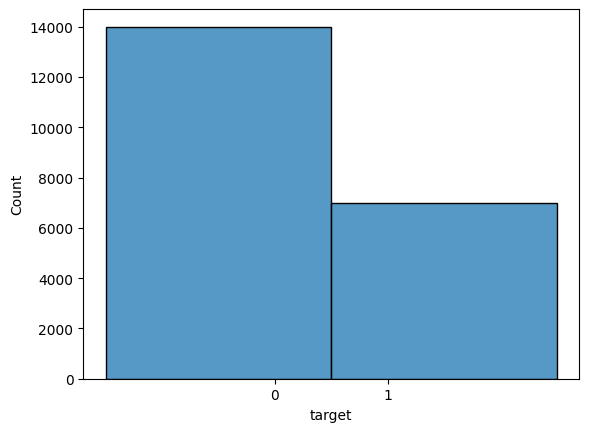

In [7]:
#checking the dsitribution of iamegs containing visually observable damaged against those which do not

ax = sns.histplot(x='target', data=train, bins=2)
ax.set_xticks([0.25,0.75])
ax.set_xticklabels([0,1])
plt.show()

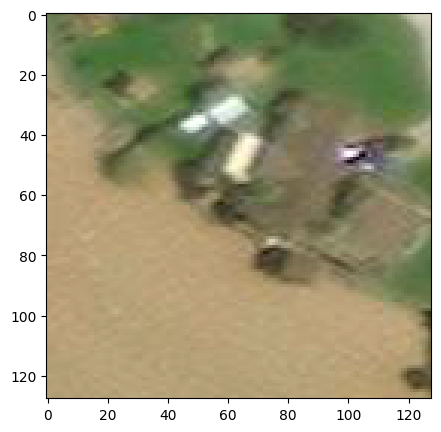

In [8]:
#plotting an image to check that the dataset has loaded in properly and the pixel size is correct

fig = plt.figure(figsize=(5,5))
plt.imshow(image_read(train[train['target']=='1']['file'].iloc[12]))

**Define the data structure for the model**

In [9]:
#using the ImageDataGenerator from TensorFlow to divide the loaded dataframes into 3 distinct variables

train_gen = ImageDataGenerator(validation_split=0.1)
test_gen = ImageDataGenerator()

train_data = train_gen.flow_from_dataframe(
    dataframe = train,
    x_col = 'file',
    y_col = 'target',
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'binary',
    shuffle = True,
    subset = 'training',
    batch_size=40
)

val_data = train_gen.flow_from_dataframe(
    dataframe = train,
    x_col = 'file',
    y_col = 'target',
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'binary',
    shuffle = False,
    subset = 'validation',
    batch_size=40
)

test_data = test_gen.flow_from_dataframe(
    dataframe = test,
    x_col = 'file',
    y_col = 'target',
    target_size = (224,224),
    color_mode = 'rgb',
    class_mode = 'binary',
    shuffle = False,
    batch_size=40
)

Found 18900 validated image filenames belonging to 2 classes.
Found 2100 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


**Create model**

In [10]:
#creating a custom CNN model

model = keras.models.Sequential([
    keras.layers.Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(224,224,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=224, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=224, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])
model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.000001),
    loss='binary_crossentropy',
    metrics=['accuracy','Recall']
)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 batch_normalization (BatchN  (None, 54, 54, 96)       384       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 224)       537824    
                                                                 
 batch_normalization_1 (Batc  (None, 26, 26, 224)      896       
 hNormalization)                                                 
                                                        

**Fit model**

In [11]:
#fitting the model on the train data

history = model.fit(train_data,epochs=5,validation_data=val_data)

Epoch 1/5
473/473 [==============================] - 63s 98ms/step - loss: 0.8536 - accuracy: 0.6978 - recall: 0.7817 - val_loss: 0.5007 - val_accuracy: 0.8186 - val_recall: 0.8186
Epoch 2/5
473/473 [==============================] - 37s 78ms/step - loss: 0.6390 - accuracy: 0.7863 - recall: 0.8442 - val_loss: 0.2846 - val_accuracy: 0.8929 - val_recall: 0.8929
Epoch 3/5
473/473 [==============================] - 38s 80ms/step - loss: 0.5461 - accuracy: 0.8138 - recall: 0.8603 - val_loss: 0.3012 - val_accuracy: 0.8867 - val_recall: 0.8867
Epoch 4/5
473/473 [==============================] - 37s 78ms/step - loss: 0.4693 - accuracy: 0.8386 - recall: 0.8773 - val_loss: 0.2708 - val_accuracy: 0.8971 - val_recall: 0.8971
Epoch 5/5
473/473 [==============================] - 37s 79ms/step - loss: 0.4156 - accuracy: 0.8549 - recall: 0.8883 - val_loss: 0.2279 - val_accuracy: 0.9110 - val_recall: 0.9110


**Evaluate model**

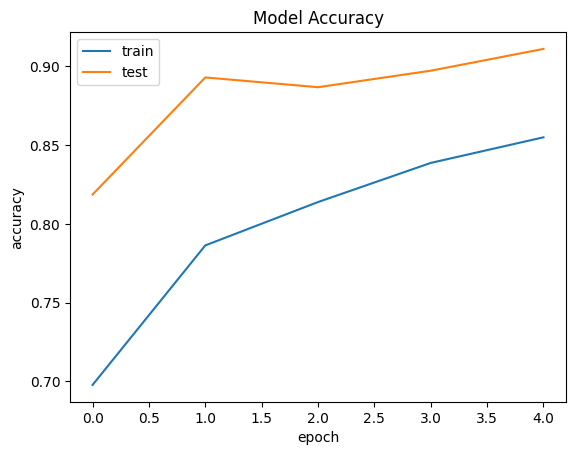

In [12]:
#generating a plot with the train and test set accuracies

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

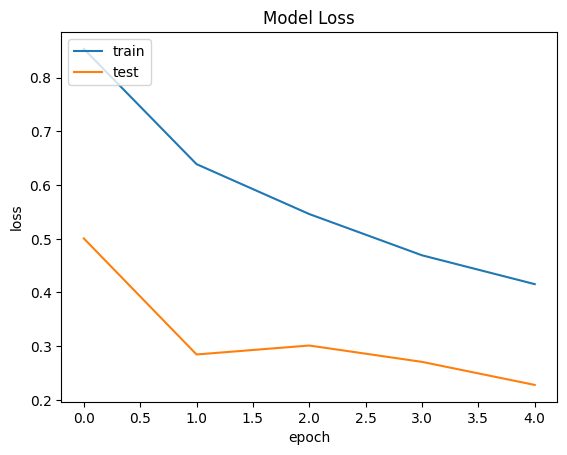

In [13]:
#generating a plot with the train and test set losses

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
#performing out of sample validation by predicting labels of data not used to train the model

y_pred = model.predict(test_data)
y_pred = np.where(y_pred > 0.5,1,0)

50/50 [==============================] - 4s 79ms/step


In [15]:
#generating a classifcation report

print(classification_report(test_data.labels,y_pred))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88      1000
           1       0.87      0.90      0.89      1000

    accuracy                           0.89      2000
   macro avg       0.89      0.89      0.89      2000
weighted avg       0.89      0.89      0.89      2000



In [16]:
#plotting a heatmap to represent the accuracy of assigning labels

con_mat_df = pd.DataFrame(confusion_matrix(test_data.labels,y_pred))

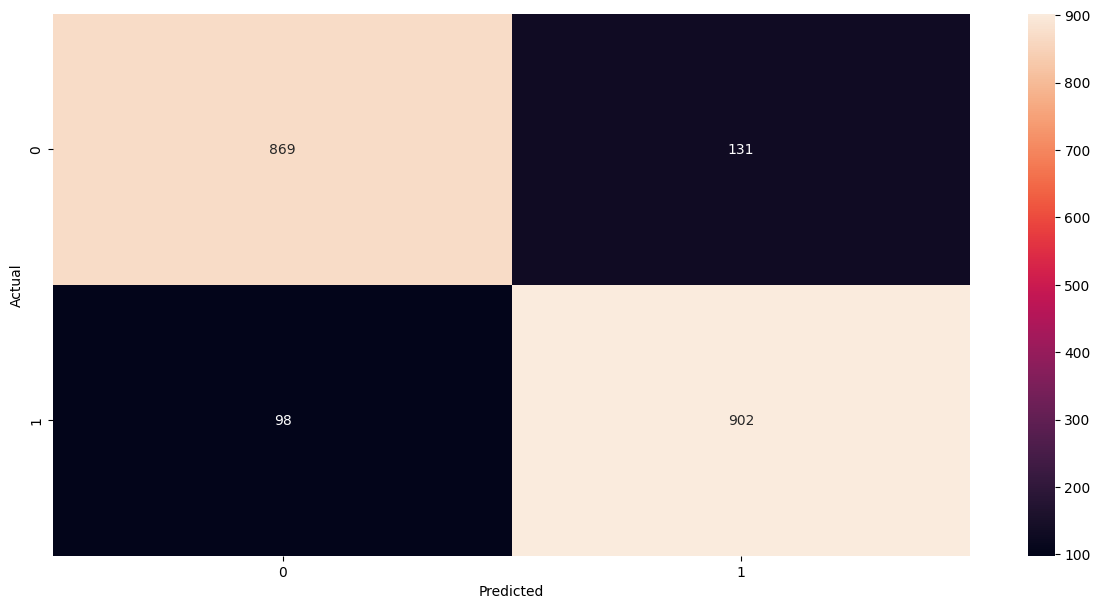

In [17]:
figure = plt.figure(figsize=(12, 6))
sns.heatmap(con_mat_df, annot=True,fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

The next step here is to peform transfer learning using the EfficientNet model with weights from the imagenet dataset

In [18]:
#defining the new model

model = tf.keras.Sequential([
        keras.layers.InputLayer(input_shape=(224,224,3)),
        keras.layers.Conv2D(3,3,activation='relu',padding='same'),
        EfficientNetB0(include_top=False,input_shape=(),weights='imagenet'),
        keras.layers.GlobalAveragePooling2D(),
        keras.layers.Dense(32,activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')])

model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.000001),
    loss='binary_crossentropy',
    metrics=['accuracy','Recall'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 224, 224, 3)       84        
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_3 (Dense)             (None, 32)                40992     
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,090,680
Trainable params: 4,048,657
Non-trainable params: 42,023
_______________________________________

The steps are then repeated as they were for the previous model

In [19]:
history = model.fit(train_data,epochs=5,validation_data=val_data)

Epoch 1/5
473/473 [==============================] - 213s 347ms/step - loss: 0.6650 - accuracy: 0.6062 - recall: 0.4723 - val_loss: 0.6451 - val_accuracy: 0.6633 - val_recall: 0.6633
Epoch 2/5
473/473 [==============================] - 162s 342ms/step - loss: 0.5713 - accuracy: 0.7896 - recall: 0.7253 - val_loss: 0.5372 - val_accuracy: 0.7843 - val_recall: 0.7843
Epoch 3/5
473/473 [==============================] - 163s 344ms/step - loss: 0.4797 - accuracy: 0.8535 - recall: 0.8087 - val_loss: 0.4399 - val_accuracy: 0.8138 - val_recall: 0.8138
Epoch 4/5
473/473 [==============================] - 162s 343ms/step - loss: 0.4012 - accuracy: 0.8741 - recall: 0.8345 - val_loss: 0.3620 - val_accuracy: 0.8348 - val_recall: 0.8348
Epoch 5/5
473/473 [==============================] - 162s 342ms/step - loss: 0.3388 - accuracy: 0.8871 - recall: 0.8546 - val_loss: 0.3152 - val_accuracy: 0.8433 - val_recall: 0.8433


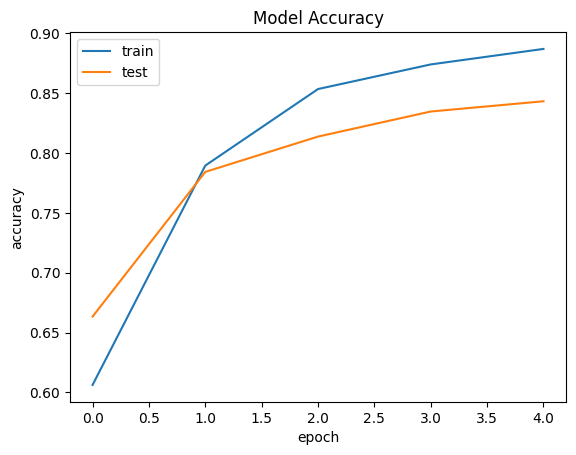

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

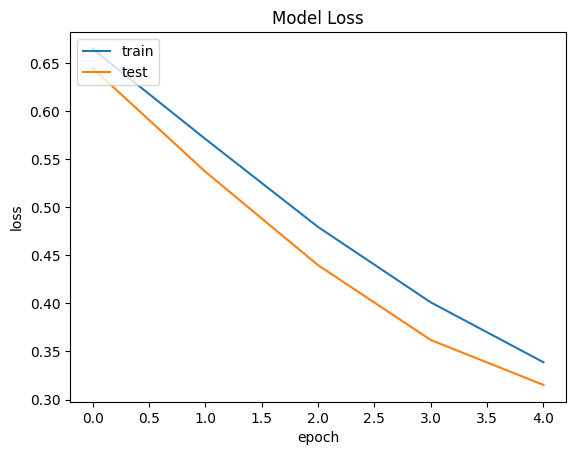

In [21]:
#plotting the loss of test and training sets
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
y_pred = model.predict(test_data)
y_pred = np.where(y_pred > 0.5,1,0)

50/50 [==============================] - 5s 76ms/step


In [23]:
print(classification_report(test_data.labels,y_pred))

              precision    recall  f1-score   support

           0       0.86      0.95      0.91      1000
           1       0.95      0.85      0.90      1000

    accuracy                           0.90      2000
   macro avg       0.91      0.90      0.90      2000
weighted avg       0.91      0.90      0.90      2000



In [24]:
con_mat_df = pd.DataFrame(confusion_matrix(test_data.labels,y_pred))

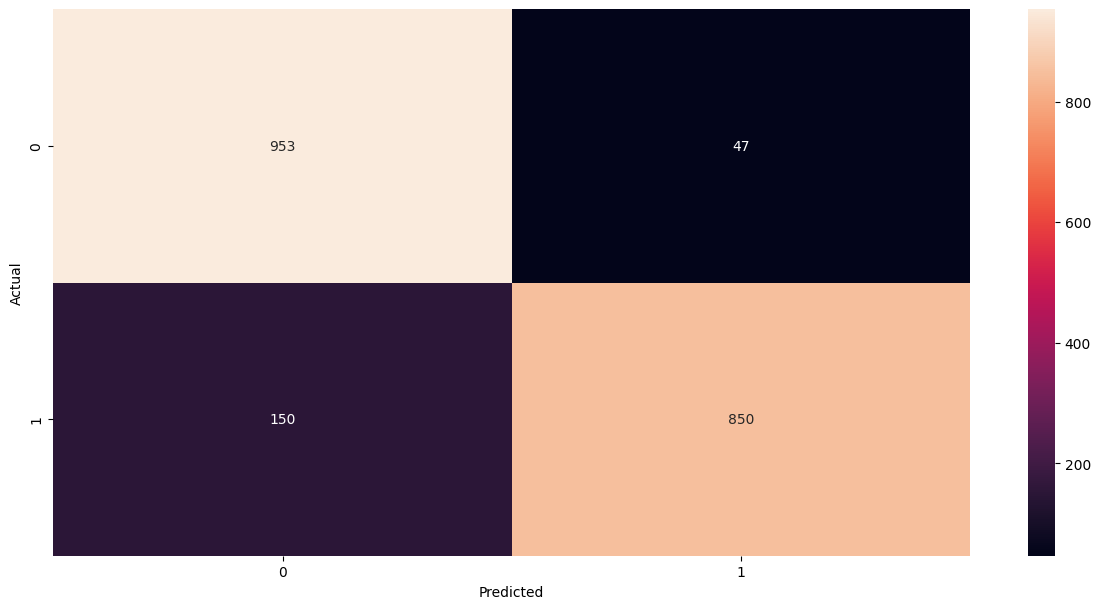

In [25]:
figure = plt.figure(figsize=(12, 6))
sns.heatmap(con_mat_df, annot=True,fmt='d')
plt.tight_layout()
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()